In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import pandas as pd
import numpy as np

In [182]:
raw = pd.read_csv('tmpkab7z67g.csv')
raw.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,police_district,neighborhood,neighborhood_services_district,ward,precinct,location_street_name,location_zipcode,latitude,longitude,source
0,101000295615,2011-07-01 02:28:04,2011-08-15 02:28:04,2011-08-01 15:21:46,ONTIME,Closed,Case Closed Case Resolved No Sidewalk and poor...,New Sign Crosswalk or Pavement Marking,Transportation - Traffic Division,Signs & Signals,...,E5,West Roxbury,12,Ward 20,2017,INTERSECTION Corey St & Lagrange St,NaN,42.3003,-71.1698,Self Service
1,101000295616,2011-07-01 03:03:48,2011-07-15 03:03:48,2011-07-22 16:13:45,OVERDUE,Closed,Case Closed Case Resolved completed,Street Light Outages,Public Works Department,Street Lights,...,E18,Hyde Park,10,Ward 18,1816,235 Fairmount Ave,2136.0,42.2496,-71.1156,Self Service
2,101000295617,2011-07-01 03:12:31,NaN,2011-07-01 06:12:38,ONTIME,Closed,Case Closed Case Resolved,Highway Maintenance,Public Works Department,Highway Maintenance,...,C11,Dorchester,7,Ward 13,1309,INTERSECTION Dorchester Ave & Hallam St,NaN,42.3144,-71.0569,Constituent Call
3,101000295618,2011-07-01 03:43:07,NaN,2011-07-05 09:16:10,ONTIME,Closed,Case Closed Case Noted,Notification,Mayor's 24 Hour Hotline,Notification,...,E13,Jamaica Plain,11,Ward 10,1006,7 Edge Hill St,2130.0,42.3243,-71.1060,Constituent Call
4,101000295619,2011-07-01 05:35:41,2011-08-15 05:35:41,2011-10-17 12:33:28,OVERDUE,Closed,Case Closed Case Noted Duplicate request,New Sign Crosswalk or Pavement Marking,Transportation - Traffic Division,Signs & Signals,...,D4,Fenway / Kenmore / Audubon Circle / Longwood,14,Ward 21,2102,INTERSECTION Arundel St & Beacon St,NaN,42.3471,-71.1033,Self Service


In [183]:
raw.shape

(1611147, 29)

In [184]:
raw.dtypes

case_enquiry_id                     int64
open_dt                            object
target_dt                          object
closed_dt                          object
ontime                             object
case_status                        object
closure_reason                     object
case_title                         object
subject                            object
reason                             object
type                               object
queue                              object
department                         object
submittedphoto                     object
closedphoto                        object
location                           object
fire_district                      object
pwd_district                       object
city_council_district              object
police_district                    object
neighborhood                       object
neighborhood_services_district     object
ward                               object
precinct                          

### Process datetime features
- Extract year, month, day, day of week information from the open_dt column.
- Calculate the service request processing time as 'duration' (in hours).

In [185]:
raw.open_dt = pd.to_datetime(raw.open_dt)
raw.closed_dt = pd.to_datetime(raw.closed_dt)

raw['duration'] = (raw.closed_dt - raw.open_dt)/np.timedelta64(1,'h')

raw['open_y'] = raw['open_dt'].dt.year
raw['open_m'] = raw['open_dt'].dt.month
raw['open_d'] = raw['open_dt'].dt.day
raw['open_day_of_week'] = raw['open_dt'].dt.dayofweek

### Filter data by year.
- Focus on 2013 - 2018 data to match with the heterogenous weather data.
- Focus on data that were processed 'ONTIME' to reduce outliers.

In [186]:
df = raw[(raw.open_y<=2018) & (raw.open_y>=2013) & (raw.ontime=='ONTIME')]
df.shape

(978370, 34)

### Deal with missing data, errant data, and useless features.
- Missing data include NaN data and data with empty string as value.
- Errant data have negative duration value. 

In [187]:
# drop useless features
to_drop = ['case_enquiry_id', 'target_dt', 'closure_reason', 'queue', 'submittedphoto', 'closedphoto', \
           'location', 'fire_district', 'pwd_district', 'police_district', 'case_status','closed_dt',\
           'neighborhood_services_district', 'ward', 'precinct', 'location_street_name', 'location_zipcode',\
           'city_council_district', 'open_dt', 'type', 'case_title', 'subject', 'ontime'\
          ]


# drop useless columns and records with missing values
df = df.drop(to_drop, axis=1).dropna(axis=0)

# drop records with ' ' values
df.drop(index=df[df['neighborhood'] == ' '].index.tolist(), inplace=True)

# drop errant data
df = df[df.duration>=0]

df.shape

(936602, 11)

### Merge 311 data with heterogenous boston weather data.

In [188]:
w = pd.read_csv('weather.csv')
w.head()

,Year,Month,Day,Avg Temp (F),Precip (in)
0,2013,1,1,29,0.0
1,2013,1,2,21,0.0
2,2013,1,3,16,0.0
3,2013,1,4,30,0.0
4,2013,1,5,35,0.0


In [189]:
new_df = pd.merge(df, w,  how='left', left_on=['open_y','open_m', 'open_d'], right_on = ['Year','Month', 'Day'])
new_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
new_df.shape

(936602, 13)

In [190]:
# drop irrelevant columns
new_df.drop(['open_d'], axis=1, inplace=True)
new_df.shape

(936602, 12)

In [191]:
new_df.head()

,reason,department,neighborhood,latitude,longitude,source,duration,open_y,open_m,open_day_of_week,Avg Temp (F),Precip (in)
0,Notification,INFO,Dorchester,42.2883,-71.0588,Constituent Call,263.208333,2013,2,4,29,0.00
1,Notification,INFO,Dorchester,42.3179,-71.0676,Constituent Call,75.201944,2013,4,4,41,0.35
2,Sanitation,PWDx,Roxbury,42.3086,-71.0855,Self Service,55.546111,2013,1,1,29,0.00
3,Sanitation,PWDx,South End,42.3440,-71.0704,Self Service,79.481944,2013,1,1,29,0.00
4,Signs & Signals,BTDT,Roxbury,42.3373,-71.0840,Constituent Call,221.571389,2013,1,1,29,0.00


In [192]:
new_df.duration.describe()

count    936602.000000
mean        226.909647
std        1092.212850
min           0.000000
25%           1.150000
50%          14.170972
75%          74.559375
max       54630.305556
Name: duration, dtype: float64

In [193]:
new_df.duration.value_counts(bins=10)

(-54.631, 5463.031]       926775
(5463.031, 10926.061]       8359
(10926.061, 16389.092]       969
(16389.092, 21852.122]       274
(21852.122, 27315.153]       109
(27315.153, 32778.183]        52
(32778.183, 38241.214]        34
(38241.214, 43704.244]        24
(49167.275, 54630.306]         3
(43704.244, 49167.275]         3
Name: duration, dtype: int64

### Modeling: classification
- Since the distribution of duration value is extremely skewed and the median value is around 0.59, for classification modeling the duration values are grouped into two classes: 
    - Class 1: processing time no more than two days (duration <= 1).
    - Class 2: processing time more than two days (duration >1 2).

In [194]:
new_df.columns

Index(['reason', 'department', 'neighborhood', 'latitude', 'longitude',
       'source', 'duration', 'open_y', 'open_m', 'open_day_of_week',
       'Avg Temp (F)', 'Precip (in)'],
      dtype='object')

In [195]:
# group duration into two classes
# 0.5 - 36hr
group_1_idx = new_df[(new_df.duration <= 24)].index.tolist()
group_2_idx = new_df[(new_df.duration > 24)].index.tolist()

new_df['class'] = [0]*new_df.shape[0]
new_df['class'].loc[group_1_idx] = 0
new_df['class'].loc[group_2_idx] = 1


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Distribution of classes')

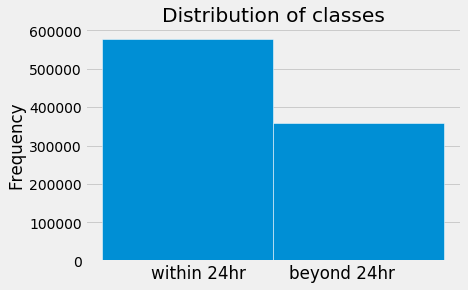

In [196]:
new_df['class'].plot(kind='hist', bins=2, edgecolor='white')
plt.xticks([])
plt.xlabel('within 24hr        beyond 24hr')
plt.title('Distribution of classes')

In [197]:
new_df.shape

(936602, 13)

In [198]:
new_df.dtypes

reason               object
department           object
neighborhood         object
latitude            float64
longitude           float64
source               object
duration            float64
open_y                int64
open_m                int64
open_day_of_week      int64
Avg Temp (F)          int64
Precip (in)         float64
class                 int64
dtype: object

In [2]:
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score,\
                            accuracy_score, roc_auc_score, roc_curve, mean_absolute_error
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [274]:
def x_processing(categorical, str_type_list, numeric):
    """
    Function for encoding categorical features and string features with onehot vectors,
    normalizing numeric features, and combining to form training features.
    categorical: all categorical features as a dataframe.
    str_type_list: a list of series have string as dtype.
    numeric: all numeric features as a dataframe
    """
    
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')

    onehotlabels = enc.fit_transform(categorical).toarray()
    print(onehotlabels.shape)
    
    for i in str_type_list:
        le = preprocessing.LabelEncoder()
        encoded = le.fit_transform(i)
        encoded = encoded.reshape(len(encoded),1)
        onehot_2 = enc.fit_transform(encoded).toarray()
        
        onehotlabels = np.hstack((onehotlabels, onehot_2))
    print(onehotlabels.shape)
    
    scaler = preprocessing.StandardScaler()
    numericlabels = scaler.fit_transform(numeric)
    print(numericlabels.shape)

    combined = np.hstack((onehotlabels, numericlabels))
    print(combined.shape)
        
    
    return combined

In [320]:
# Process X
X_combine = x_processing(new_df[['open_y']],\
                         [new_df['department'], new_df['reason'], new_df['source'], new_df['neighborhood']],\
                         new_df[['Avg Temp (F)', 'Precip (in)', 'open_m', 'open_day_of_week']])


(936602, 6)
(936602, 103)
(936602, 4)
(936602, 107)


### Dimension reduction by PCA.

Text(0.5, 1.0, 'Principal Component Analysis')

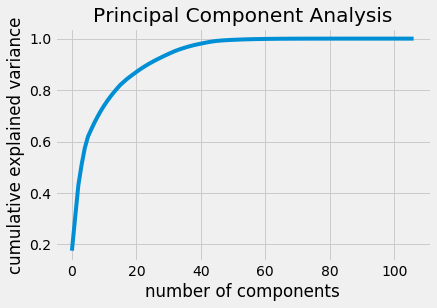

In [321]:
# PCA
pca = PCA().fit(X_combine)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Principal Component Analysis')

In [322]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_combine)
X_pca.shape

(936602, 20)

### Split data into training, testing, and validation sets.

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, new_df['class'], 
                                                    test_size=0.1, 
                                                    random_state=0, 
                                                    shuffle=True)



### Test various classifiers and compare performance and error metrics.
- Distance-based classifiers are not included because of their time cost on training large datasets.
- Classifiers included:
    - Dummy classifier (baseline)
    - Logistic regression classifier
    - Decision tree classifier
    - Random forest classifier
    - AdaBoost
    - SGD classifier


In [280]:
param_grid = {
    'Logistic regression': {
        'solver': ['lbfgs']#['sag', 'lbfgs', 'liblinear']        
    },
    'Decision Tree': {
        'criterion': ['entropy'], #['gini', 'entropy'],
        'max_features': ['auto'],# 'sqrt', 'log2']
    },
    'Random Forest': {
        'criterion': ['entropy'],#['gini', 'entropy'],
        'max_features': ['auto'],# 'sqrt', 'log2']
        'min_samples_split': [2],#,4],
        'min_samples_leaf': [4],#[1,4]
        'n_estimators': [10]
    },
    'SGD': {
        'loss': ['log'],
        'max_iter': [1000],
        'tol': [1e-3]
    }
}

In [281]:
def clf_methods(clfs, X_train, y_train, X_test, y_test):
    """
    Classifiers tune-train-test.
    """
    roc_curve_dict = {}
    acc = {}
    f1 = {}
    
    for c in clfs:
        if c == 'Dummy':
            clf = DummyClassifier(strategy='most_frequent')
        elif c == 'Logistic regression':
            clf = GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
                               param_grid=param_grid['Logistic regression'], n_jobs=-1,
                               scoring='roc_auc')
        elif c == 'Decision Tree':
            clf = GridSearchCV(cv=5, estimator=tree.DecisionTreeClassifier(random_state=0),
                               param_grid=param_grid['Decision Tree'], n_jobs=-1,
                               scoring='roc_auc')
        elif c == 'Random Forest':
            clf = GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                               param_grid=param_grid['Random Forest'], n_jobs=-1,
                               scoring='roc_auc')
        elif c == 'AdaBoost':
            clf = AdaBoostClassifier(random_state=0)
        elif c == 'SGD':
            clf = GridSearchCV(cv=5, estimator=SGDClassifier(random_state=0),
                               param_grid=param_grid['SGD'], n_jobs=-1,
                               scoring='roc_auc')
            
        
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        roc_curve_dict[c] = (fpr, tpr)
        f1[c] = f1_score(y_test, pred)
        acc[c] = accuracy_score(y_test, pred)
        
        print(c)
        print('Accuracy: ', "%.2f" % acc[c])
        print('F1: ', "%.2f" % f1[c])
        print('ROC_AUC: ', "%.2f" % roc_auc_score(y_test, pred))
        print('=================================')
        
        
    return roc_curve_dict, acc, f1

In [282]:
clfs = ['Dummy', 'Logistic regression', 'Decision Tree', 'Random Forest', 'AdaBoost', 'SGD']
roc_curve_dict, acc, f1 = clf_methods(clfs, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Dummy
Accuracy:  0.62
F1:  0.00
ROC_AUC:  0.50
Logistic regression
Accuracy:  0.73
F1:  0.63
ROC_AUC:  0.71
Decision Tree
Accuracy:  0.78
F1:  0.70
ROC_AUC:  0.76
Random Forest
Accuracy:  0.80
F1:  0.73
ROC_AUC:  0.79
AdaBoost
Accuracy:  0.74
F1:  0.65
ROC_AUC:  0.72
SGD
Accuracy:  0.73
F1:  0.64
ROC_AUC:  0.71


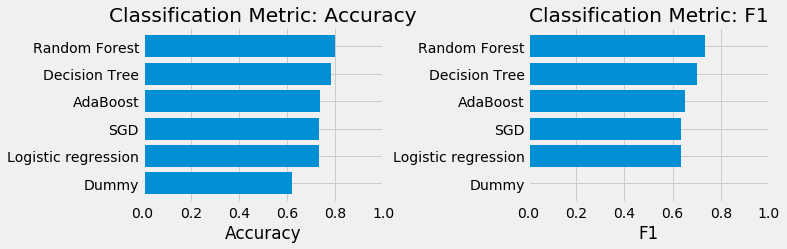

In [283]:
sorted_acc = sorted(acc.items() , key=lambda x: x[1])
sorted_f1 = sorted(f1.items() , key=lambda x: x[1])

plt.figure(figsize=(10,3))

p1 = plt.subplot(121)
p1.barh(range(len(sorted_acc)), [i[1] for i in sorted_acc])
p1.set_xlim([0, 1])
plt.yticks(range(len(sorted_f1)),[i[0] for i in sorted_f1])
plt.xlabel('Accuracy')
plt.title('Classification Metric: Accuracy')

p2 = plt.subplot(122)
p2.barh(range(len(sorted_f1)), [i[1] for i in sorted_f1])
p2.set_xlim([0, 1])
plt.yticks(range(len(sorted_f1)),[i[0] for i in sorted_f1])
plt.xlabel('F1')
plt.title('Classification Metric: F1')



plt.subplots_adjust(wspace=0.6)

Text(0.5, 0, 'False Positive Rate')

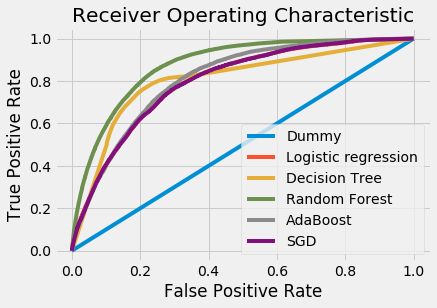

In [284]:
for c in roc_curve_dict.keys():
    fpr,tpr = roc_curve_dict[c]
    plt.plot(fpr,tpr,label=c)
    
plt.legend(loc=4)
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Test various regressors and compare performance and error metrics.
- Regressors included:
    - Dummy regressor
    - Decision tree regressor
    - Random forest regressor
    - Gradient boosting regressor
    - Linear regressor


In [323]:
# convert duration from hours to days.
new_df['duration'] = new_df['duration']/24
new_df[(new_df['reason']=='Sanitation')]['duration'].describe()

count    171069.000000
mean          3.386809
std           4.126719
min           0.000093
25%           0.651840
50%           2.287998
75%           5.327789
max         633.062025
Name: duration, dtype: float64

In [324]:
re = new_df[(new_df['reason']=='Sanitation')]
re_label = new_df[(new_df['reason']=='Sanitation')]['duration']
re.shape

(171069, 13)

In [325]:
re.head()

,reason,department,neighborhood,latitude,longitude,source,duration,open_y,open_m,open_day_of_week,Avg Temp (F),Precip (in),class
2,Sanitation,PWDx,Roxbury,42.3086,-71.0855,Self Service,2.314421,2013,1,1,29,0.0,1
3,Sanitation,PWDx,South End,42.3440,-71.0704,Self Service,3.311748,2013,1,1,29,0.0,1
6,Sanitation,PWDx,Mission Hill,42.3289,-71.1006,Self Service,0.143519,2013,1,1,29,0.0,0
9,Sanitation,PWDx,Allston / Brighton,42.3527,-71.1478,Self Service,7.505185,2013,1,1,29,0.0,1
11,Sanitation,PWDx,Jamaica Plain,42.3099,-71.1050,Self Service,4.443299,2013,1,1,29,0.0,1


In [341]:
re_combine = x_processing(re[['open_y']],\
                        [re['department'], re['source'], re['neighborhood'], re['reason']],\
                        re[['Avg Temp (F)', 'Precip (in)', 'open_m', 'open_day_of_week']])


(171069, 6)
(171069, 40)
(171069, 4)
(171069, 44)


In [342]:
X_train, X_test, y_train, y_test = train_test_split(re_combine, re_label, 
                                                    test_size=0.1, 
                                                    random_state=0, 
                                                    shuffle=True)

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.dummy import DummyRegressor


In [344]:
param_grid_r = {
    'Decision Tree': {
        'max_features': ['log2'],#['auto', 'sqrt', 'log2'],
        'min_samples_split': [2],#[2,3,4],
        'min_samples_leaf': [4]#[1,2,4]
        
    },
    'Random Forest': {
        'n_estimators': [50],#[10, 50],
        'max_features': ['log2'],#['auto', 'sqrt', 'log2'],
        'min_samples_split': [4],#[2,3,4]
    },
    'Gradient Boosting': {
        'max_features': ['sqrt'],# 'log2'],#['auto', 'sqrt'],
        'learning_rate': [0.1],#0.01],
        'min_samples_split': [4],#[2,3,4],
        'max_depth': [4]#[3,4,5]
    }
}

In [345]:
def regr_methods(regrs, X_train, y_train, X_test, y_test):
    """
    Regressors tune-train-test.
    """
    param = {}
    mae = {}
    rmse = {}
    r2 = {}
    for r in regrs:
        if r == 'Dummy':
            regr = DummyRegressor(strategy='mean')
        elif r == 'Decision Tree':
            regr = GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
                                param_grid=param_grid_r['Decision Tree'], n_jobs=-1,
                                scoring='r2')
        elif r == 'Random Forest':
            regr = GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                                param_grid=param_grid_r['Random Forest'], n_jobs=-1,
                                scoring='r2')
        elif r == 'Gradient Boosting':
            regr = GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0, n_estimators=200),
                                param_grid=param_grid_r['Gradient Boosting'], n_jobs=-1,
                                scoring='r2')
        elif r == 'Linear':
            regr = LinearRegression()


        
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        
        param[r] = regr
        mae[r] = mean_absolute_error(y_test, pred)
        rmse[r] = np.sqrt(mean_squared_error(y_test, pred))
        r2[r] = r2_score(y_test, pred)
        print(r)
        print("Mean absolute error: %.2f" % mae[r])
        print("Mean squared error: %.2f" % rmse[r])
        print('R2: %.2f' % r2[r])
        print('=================================')
        
    return param, mae, rmse, r2
       

In [346]:
regrs = ['Dummy', 'Decision Tree', 'Random Forest','Gradient Boosting', 'Linear']
param, mae, rmse, r2 = regr_methods(regrs, X_train, y_train, X_test, y_test)


Dummy
Mean absolute error: 2.74
Mean squared error: 3.79
R2: -0.00
Decision Tree
Mean absolute error: 2.53
Mean squared error: 3.59
R2: 0.11
Random Forest
Mean absolute error: 2.49
Mean squared error: 3.59
R2: 0.11
Gradient Boosting
Mean absolute error: 2.52
Mean squared error: 3.49
R2: 0.15
Linear
Mean absolute error: 2.58
Mean squared error: 3.63
R2: 0.08


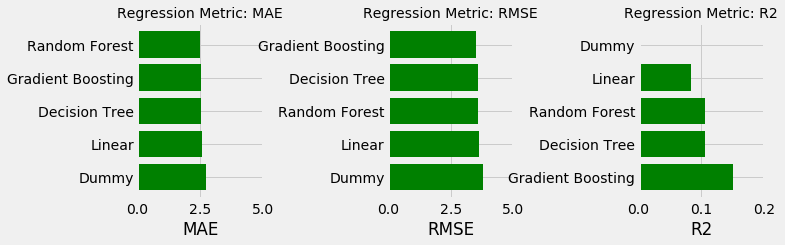

In [363]:
sorted_rmse = sorted(rmse.items() , reverse=True, key=lambda x: x[1])
sorted_r2 = sorted(r2.items() , reverse=True, key=lambda x: x[1])
sorted_mae = sorted(mae.items() , reverse=True, key=lambda x: x[1])

plt.figure(figsize=(10,3))

p1 = plt.subplot(1, 3, 1)
p1.barh(range(len(sorted_mae)), [i[1] for i in sorted_mae], color='green')
p1.set_xlim([0, 5])
plt.yticks(range(len(sorted_mae)),[i[0] for i in sorted_mae])
plt.xlabel('MAE')
plt.title('Regression Metric: MAE', fontsize=14)

p2 = plt.subplot(1, 3, 2)
p2.barh(range(len(sorted_rmse)), [i[1] for i in sorted_rmse], color='green')
p2.set_xlim([0, 5])
plt.yticks(range(len(sorted_rmse)),[i[0] for i in sorted_rmse])
plt.xlabel('RMSE')
plt.title('Regression Metric: RMSE', fontsize=14)

p3 = plt.subplot(1, 3, 3)
p3.barh(range(len(sorted_r2)), [i[1] for i in sorted_r2], color='green')
p3.set_xlim([0, 0.2])
plt.yticks(range(len(sorted_r2)),[i[0] for i in sorted_r2])
plt.xlabel('R2')
plt.title('Regression Metric: R2', fontsize=14)


plt.subplots_adjust(wspace=1)